In [1]:
import sys; sys.path.insert(0,'../')
from dist_tools import *

%matplotlib inline

seats, fips, epsg = 13, 12, 3513
years = [2008]
cols = ["D08", "R08"]

Optimization terminated successfully.
         Current function value: 0.146857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170656
         Iterations 7


/home/jsaxon/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
! ls /media/jsaxon/brobdingnag/data/el_dv/fl/

fl_final.dbf  fl_final.sbx  fl_final.tab       FL_Shapefile.zip
fl_final.prj  fl_final.shp  FL_notes_0927.rtf  MANIFEST.TXT
fl_final.sbn  fl_final.shx  fl_proj.qqs.qgs


In [3]:
votes = gpd.read_file("/media/jsaxon/brobdingnag/data/el_dv/fl/fl_final.shp").to_crs(epsg = epsg)
votes.rename(columns = {"PRES_DEM_0" : "D08", "PRES_REP_0" : "R08"}, inplace = True)
votes = votes[["D08", "R08", "geometry"]]

print(list(votes.columns))

votes["DFrac"] = votes["D08"] / (votes["D08"] + votes["R08"])
output_geojson(votes.set_geometry(votes.geometry.simplify(10)), var = "DFrac", fname = "mapped/fl_2008.geojson")

['D08', 'R08', 'geometry']


In [4]:
query = """SELECT 
              rn, ST_Transform(tr.geom, epsg) geometry
           FROM census_tracts_2015 AS tr
           JOIN (SELECT state, county, tract,
                        row_number() over 
                          (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                 FROM census_tracts_2015) rn ON
                   tr.state  = rn.state  AND
                   tr.county = rn.county AND
                   tr.tract  = rn.tract
           JOIN states AS st ON st.fips = tr.state
           WHERE tr.state = {} ORDER BY rn;
           """

con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

tr_rn = gpd.GeoDataFrame.from_postgis(query.format(fips), con, geom_col = "geometry", crs = from_epsg(epsg))

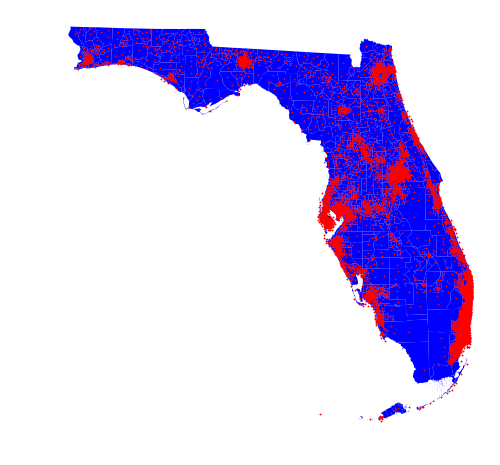

In [5]:
ax = tr_rn.plot(color = "blue", markersize = 3, figsize = (8, 8))
votes.centroid.plot(color = "red", markersize = 2, ax = ax)
ax.set_axis_off()

In [6]:
votes_merged = merge_tract_number(tr_rn, votes)[["D08", "R08"]]
votes_merged.to_csv("votes/fl.csv", index = True)
# votes_merged.head(10)